In [2]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


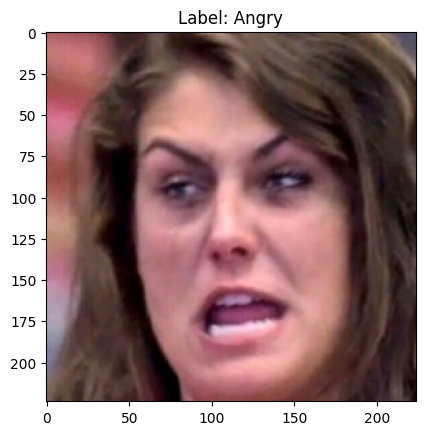

In [9]:
from matplotlib import pyplot as plt

# Display a sample image with its label
img, label = train_dataset[0]  # Get the first image and label
plt.imshow(img.permute(1, 2, 0) * 0.5 + 0.5)  # Unnormalize for display
plt.title(f"Label: {train_dataset.classes[label]}")
plt.show()


**Fine-Tuning Vision Transformers For Emotion Detection**

In [2]:
# !pip install torch torchvision transformers datasets matplotlib

**REQUIRED LIBRARIES INSTALLING**

In [26]:
import os
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import random
import seaborn as sns
from transformers import ViTForImageClassification
import torch
import torch.nn as nn
from torch.optim import AdamW
from tqdm import tqdm

**DATASET PATH SETTING UP AND APPLYING TRANSFORMATIONS**

In [6]:
# Dataset paths
train_path = '/kaggle/input/emotion-data/custom_data/train'
test_path = '/kaggle/input/emotion-data/custom_data/test'

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),  # Convert image to PyTorch Tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

**LOADING DATASET AND DATALOADERS**

In [7]:
# Load datasets
train_dataset = datasets.ImageFolder(root=train_path, transform=transform)
test_dataset = datasets.ImageFolder(root=test_path, transform=transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [11]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 11553
    Root location: /kaggle/input/emotion-data/custom_data/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )

In [12]:
# Print dataset info
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")
print(f"Classes: {train_dataset.classes}")

Number of training samples: 11553
Number of testing samples: 2688
Classes: ['Angry', 'Happy', 'Neutral', 'Sad', 'Surprise']


**EDA (EXPLORATORY-DATA-ANALYSIS ON IMAGE DATA)**

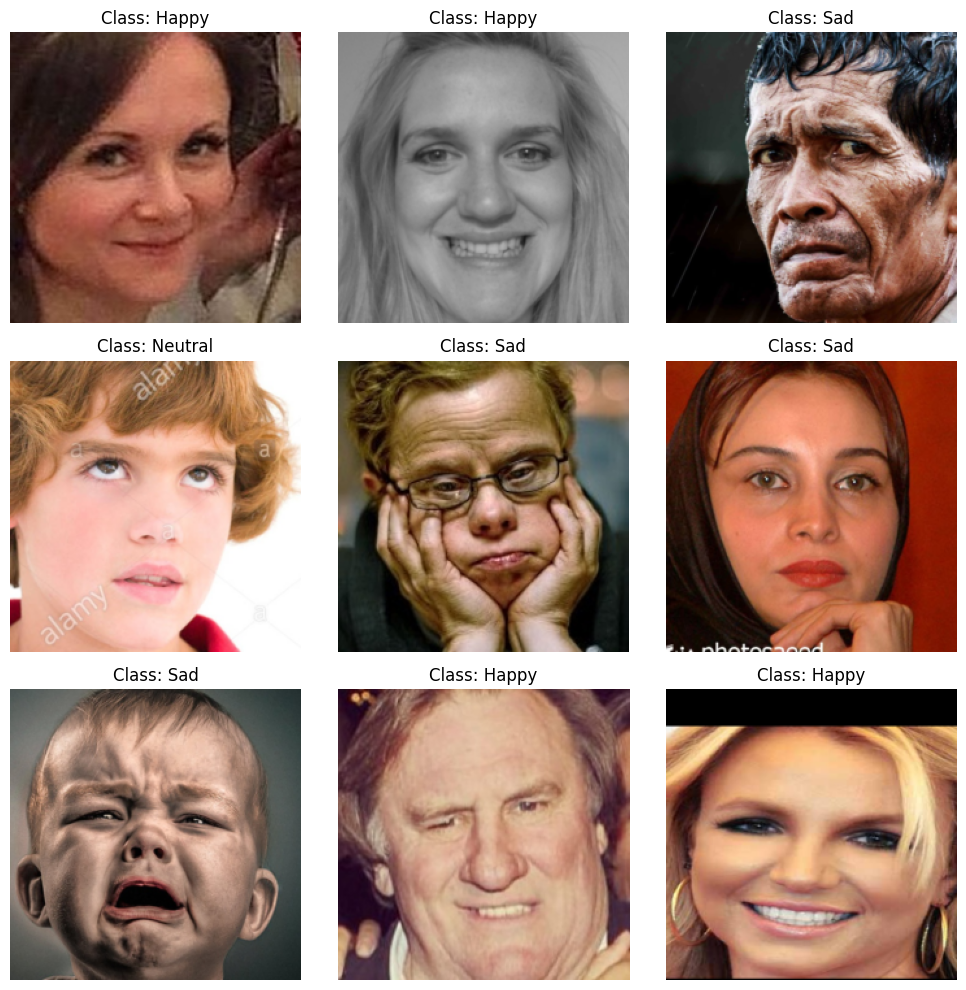

In [13]:
# Display some random images
def show_random_images(dataset):
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    for i in range(9):
        idx = random.randint(0, len(dataset) - 1)
        img, label = dataset[idx]
        img = img.permute(1, 2, 0)  # Convert from CHW to HWC
        img = (img * 0.5 + 0.5).clip(0, 1)  # De-normalize
        axes[i // 3, i % 3].imshow(img)
        axes[i // 3, i % 3].set_title(f"Class: {train_dataset.classes[label]}")
        axes[i // 3, i % 3].axis("off")
    plt.tight_layout()
    plt.show() 

show_random_images(train_dataset)

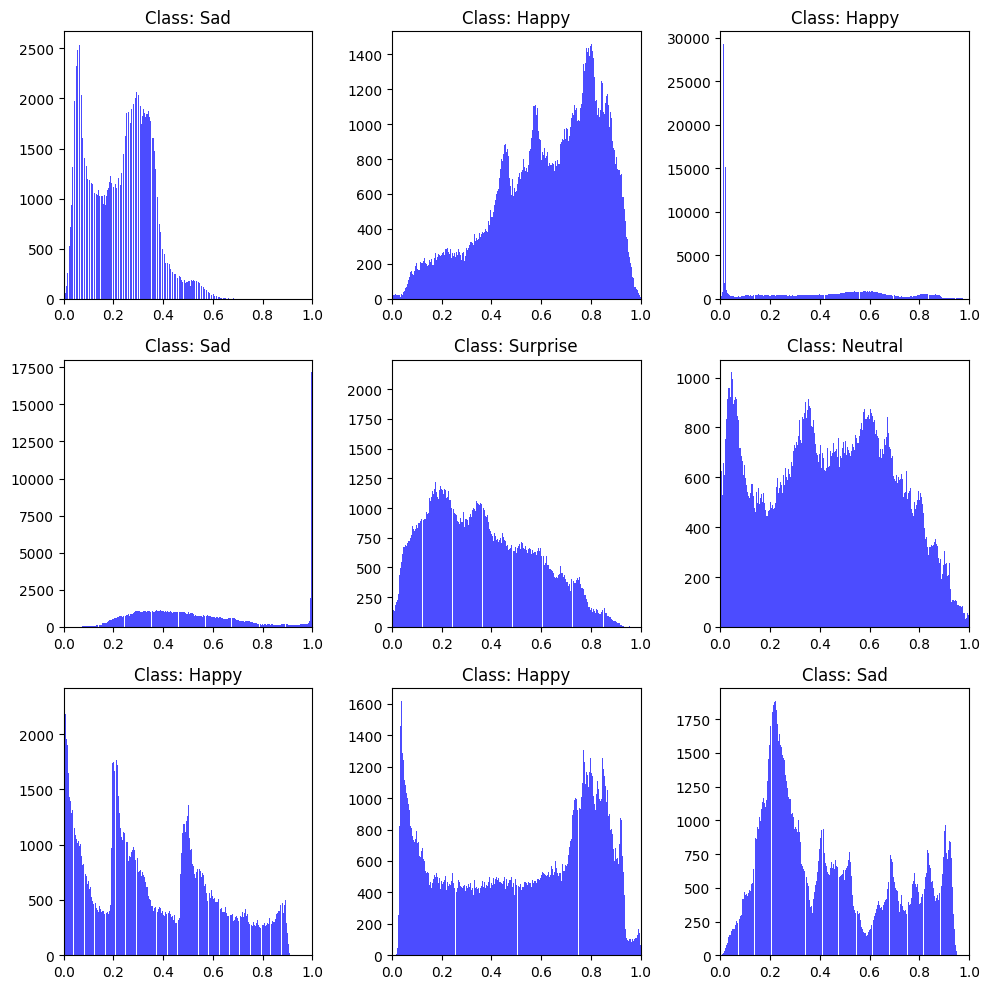

In [16]:
def show_image_histograms(dataset):
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    for i in range(9):
        idx = random.randint(0, len(dataset) - 1)
        img, label = dataset[idx]
        img = img.permute(1, 2, 0).numpy()  # Convert to numpy
        img = (img * 0.5 + 0.5).clip(0, 1)  # De-normalize
        axes[i // 3, i % 3].hist(img.ravel(), bins=256, color="blue", alpha=0.7)
        axes[i // 3, i % 3].set_title(f"Class: {train_dataset.classes[label]}")
        axes[i // 3, i % 3].set_xlim(0, 1)
    plt.tight_layout()
    plt.show()

show_image_histograms(train_dataset)


In [25]:
# Load the pre-trained ViT model
model_name = "google/vit-base-patch16-224"
model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=len(train_dataset.classes),  # Match number of classes
    ignore_mismatched_sizes=True  # Resolve size mismatch in the classifier layer
)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=5e-5)

In [28]:
# Training loop
epochs = 5
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images).logits
        loss = criterion(outputs, labels)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Track metrics
        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss:.4f}, Accuracy: {correct / total:.4f}")

100%|██████████| 723/723 [05:41<00:00,  2.12it/s]


Epoch 1/5, Loss: 403.4411, Accuracy: 0.7804


100%|██████████| 723/723 [05:09<00:00,  2.33it/s]


Epoch 2/5, Loss: 181.7697, Accuracy: 0.9031


100%|██████████| 723/723 [05:10<00:00,  2.33it/s]


Epoch 3/5, Loss: 78.8902, Accuracy: 0.9618


100%|██████████| 723/723 [05:09<00:00,  2.33it/s]


Epoch 4/5, Loss: 40.4879, Accuracy: 0.9823


100%|██████████| 723/723 [05:13<00:00,  2.31it/s]

Epoch 5/5, Loss: 34.8457, Accuracy: 0.9821


In [36]:
# Save the model after training
model.save_pretrained("/kaggle/working/")




In [31]:
# Load the model
model.load_state_dict(torch.load(save_path))
model.eval()

# Evaluate on test set
correct = 0
total = 0

with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).logits
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

print(f"Test Accuracy: {correct / total:.4f}")


/tmp/ipykernel_23/4117075897.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path))
100%|██████████| 168/168 [00:48<00:00,  3.49it/

Test Accuracy: 0.7269


In [39]:
import torch
from transformers import ViTForImageClassification
from PIL import Image
from torchvision import transforms

# Load the saved model
model = ViTForImageClassification.from_pretrained("/kaggle/working/")
model.eval()  # Set the model to evaluation mode

# Define the same transformation used during training
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to model input size
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # Normalize
])

# Load a random image
image_path = "/kaggle/input/newwdta/cropped_emotions.570035.png"  # Replace with the path to your image
image = Image.open(image_path).convert("RGB")  # Convert to RGB (in case it's grayscale)
input_tensor = transform(image).unsqueeze(0)   # Add batch dimension

# Perform inference
with torch.no_grad():
    outputs = model(input_tensor)
    logits = outputs.logits
    predicted_class_idx = torch.argmax(logits, dim=1).item()

# Map the prediction to the class label
class_labels = train_dataset.classes  # Load from your dataset definition
predicted_label = class_labels[predicted_class_idx]

# Print the result
print(f"Predicted class: {predicted_label}")

Predicted class: Happy


In [ ]:
!zip -r kaggle_working.zip /kaggle/working/

In [44]:
from IPython.display import FileLink

# Create a download link for the .zip file
FileLink("/kaggle/working/kaggle_working.zip")

/kaggle/working/kaggle_working.zip